# Временной ряд

In [193]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime
from tqdm import tqdm
from tensorflow.keras import utils
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

#from google.colab import files
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [194]:
df = pd.read_csv('airline-passengers.csv')
df.index = df.Month.sort_index(ascending=True)
df.drop(['Month'],axis = 1,inplace = True)

In [195]:
df.head()

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


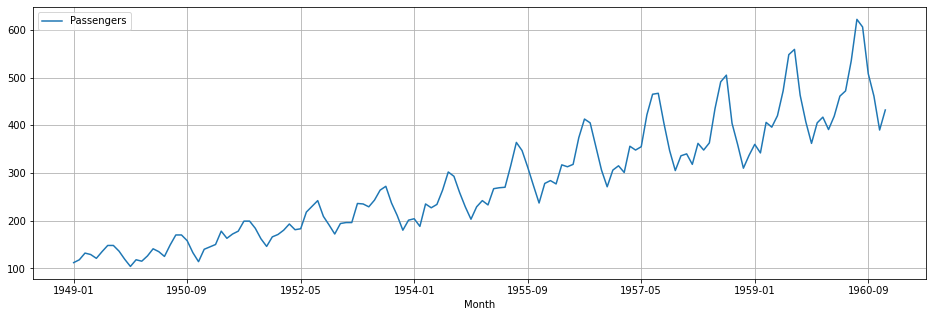

In [196]:
df.plot( figsize = (16,5))
plt.grid('On')
plt.show()

In [197]:
df.describe()

,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


Добавим дату как признаки:
как "месяц в году"

In [198]:
df['month'] = pd.to_datetime(df.index).month
df['year'] = pd.to_datetime(df.index).year - 1949
df.head()

,Passengers,month,year
Month,,,
1949-01,112,1,0
1949-02,118,2,0
1949-03,132,3,0
1949-04,129,4,0
1949-05,121,5,0


Делаем нормализацию

In [199]:
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(df)
data = pd.DataFrame(data, columns=df.columns.to_list(), index=df.index)
data.shape, df.shape

((144, 3), (144, 3))

In [200]:
data.describe()

,Passengers,month,year
count,144.000000,144.000000,144.000000
mean,0.340345,0.500000,0.500000
std,0.231595,0.314918,0.314918
min,0.000000,0.000000,0.000000
25%,0.146718,0.250000,0.250000
50%,0.311776,0.500000,0.500000
75%,0.495174,0.750000,0.750000
max,1.000000,1.000000,1.000000


Создаем данные для обучения

In [201]:
# список признаков, по которым будем учить
channelIndexes = list(range(3)) # BRENT
train_split = 90

# длина теста
valLen = data.shape[0] - train_split
# длина истории для работы
xLen = 5
# отступ тестов от тренировок
bias = 5

# вычисляем точку разделения ряда на тесты и тренировку

# делим
train_data = data.iloc[0 : train_split ,channelIndexes]
val_data = data.iloc[train_split+bias:,channelIndexes]

Формируем параметры для генерации выборки

In [202]:
# шаг по данным для построения обучающих примеров
step = 1

# длина прошлого 
past = xLen
p = past
# горизонт предсказания
future = 1
h=future

Выделяем части на обучение и проверку

In [203]:
Chanel_numb = len(channelIndexes)

start = xLen + future
end = start + train_split-1

xTrain_df = train_data.iloc[:-future-xLen+1,:] # сдвиг по времени для предсказания (закончить чуть раньше)
xTrain = xTrain_df[[train_data.columns[i] for i in range(Chanel_numb)]].values
yTrain = train_data.iloc[future+xLen-1:,0].values  # сдвиг по времени для предсказания (начать чуть позднее)

sequence_length = int(xLen / step)


x_end = len(val_data) - xLen - future 

label_start = len(train_data)+bias+xLen + future +1

xVal_df = val_data.iloc[:-future-xLen+1,:] # сдвиг по времени для предсказания (закончить чуть раньше)
xVal = xVal_df[[val_data.columns[i] for i in range(Chanel_numb)]].values
yVal = val_data.iloc[future+xLen-1:,0].values  # сдвиг по времени для предсказания (начать чуть позднее)

print(xTrain.shape)
print(yTrain.shape)
print(xVal.shape)
print(yVal.shape)

(85, 3)
(85,)
(44, 3)
(44,)


Посмотрим на них

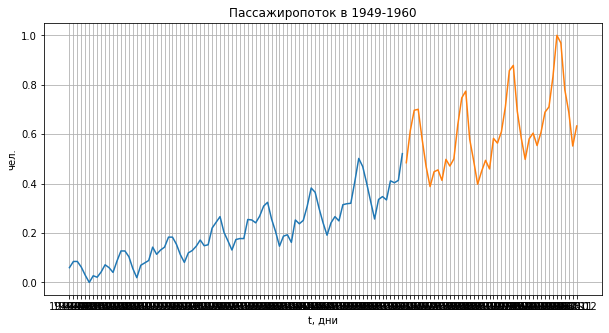

In [204]:
plt.figure(figsize = (10,5))
plt.plot(data.index[xLen:yTrain.shape[0]+xLen],yTrain[:])
plt.plot(data.index[yTrain.shape[0]+bias+future+2*xLen-1:],yVal[:])
plt.grid()
plt.xlabel('t, дни')
plt.ylabel('чел.')
plt.title('Пассажиропоток в 1949-1960')
plt.show()

Используем механизм формирования пакетов для обучения

In [205]:
batch_size = 32

dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    xTrain,
    yTrain,
    sequence_length = xLen,
    sampling_rate = 1,
    batch_size = batch_size,
)
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    xVal,
    yVal,
    sequence_length = xLen,
    sampling_rate = 1,
    batch_size = batch_size,
)


Подключим инструмент наблюдения Tensorboard.

In [206]:
logdir = os.path.join("logs2", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard( logdir, histogram_freq=1)

Проверим , что все верно (для Х[i,xLen, :] y[i] - необходимо контролировать, что Х[i,xLen,0] не входит y[i])

In [207]:
for batch in dataset_val.take(2):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (8, 5, 3)
Target shape: (8,)


In [208]:
for batch in dataset_train.take(2):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (32, 5, 3)
Target shape: (32,)


# Практическое задание

<ol>
    <li>Попробуйте обучить нейронную сеть LSTM на любом другом датасете (любимый временной ряд, текст на русском (другом языке) как генератор или классификатор, или прилагаемый набор airline-passengers - пасажиропоток для авиалиний). Опишите, какой результата вы получили? Что помогло вам улучшить ее точность?
</ol>

In [209]:
callbaсk = EarlyStopping(monitor='val_mae', patience=2)

model = Sequential()

model.add(LSTM(64, input_shape = (inputs.shape[1], inputs.shape[2]), return_sequences="True"))
model.add(LSTM(32, return_sequences = "True"))
model.add(Conv1D(32, 2, activation = "linear", padding='same'))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(Flatten())                          
model.add(Dense(32, activation = "linear"))      

model.add(Dense(1, activation = "linear"))

model.compile(loss = "mse", optimizer = "adam", metrics = ['mae'])
# Посмотрим на модель LSTM
#utils.plot_model(model,'model_stek.png', show_shapes=True)
model.summary()
hist_val = []
hist_train = []

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_63 (LSTM)              (None, 5, 64)             17408     
                                                                 
 lstm_64 (LSTM)              (None, 5, 32)             12416     
                                                                 
 conv1d_34 (Conv1D)          (None, 5, 32)             2080      
                                                                 
 max_pooling1d_20 (MaxPoolin  (None, 3, 32)            0         
 g1D)                                                            
                                                                 
 flatten_30 (Flatten)        (None, 96)                0         
                                                                 
 dense_43 (Dense)            (None, 32)                3104      
                                                     

100%|██████████| 10/10 [00:16<00:00,  1.62s/it]


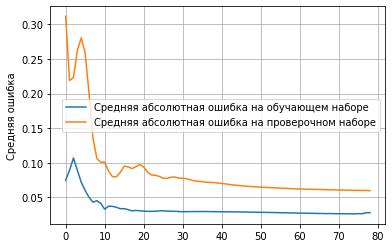

In [210]:
# параметры модели для обучения
epochs = 10

for i in tqdm(range(epochs)):
    history = model.fit(
        dataset_train,
        epochs = epochs,
        validation_data = dataset_val,
        callbacks = [callbaсk, tensorboard_callback],
        verbose=0)

    hist_val.extend(history.history['val_mae'][:])
    hist_train.extend(history.history['mae'][:])

plt.plot(hist_train[1:], 
         label = 'Средняя абсолютная ошибка на обучающем наборе')
plt.plot(hist_val[1:], 
         label = 'Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.grid()
plt.show()

Проверяем результаты:

- строим предсказание
- рисуем прогноз для тестовой части 
- рисуем прогноз по тренировочной части

In [211]:
pred = model.predict(dataset_train).flatten()
predVal = model.predict(dataset_val).flatten()

2/2 [==============================] - 0s 5ms/step


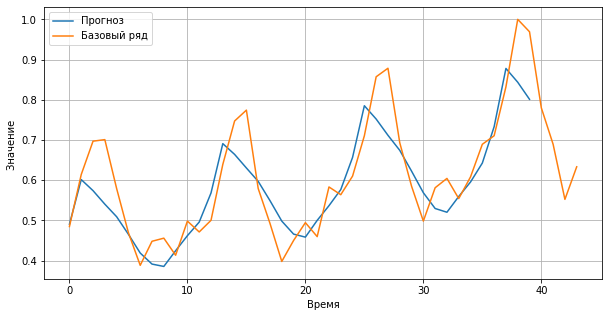

In [212]:
start = 0
step = 150
plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(predVal[start:start+step], 
         label = 'Прогноз')
plt.plot(yVal.flatten()[start:start+step], 
         label = 'Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

Тренировочные даннные:

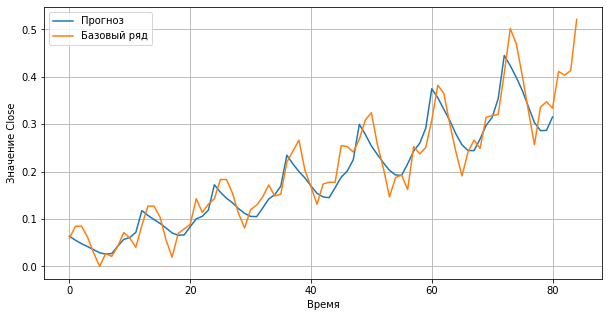

In [213]:
start = 0


plt.figure(figsize = (10,5))
plt.grid('on')
plt.plot(pred[start:train_split], 
         label = 'Прогноз')
plt.plot(yTrain.flatten()[start:train_split], 
         label = 'Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение Close')
plt.legend()
plt.show()

Проверяем качество модели:
- оценим по лаговой корреляции рядов a, b;
- если наибольшая корреляция с лагом 0, то отлично;
- есди максимум корреляциии на лаге , равном глубине прогноза, то тривиальное предсказание (завтра, как сегодня).


In [214]:
def correlate(a, b):
    ma = a.mean()
    mb = b.mean()
    mab = (a*b).mean()
    sa = a.std()
    sb = b.std()
    
    val = 0
    if ((sa>0) & (sb>0)):
        val = (mab-ma*mb)/(sa*sb)
    return val

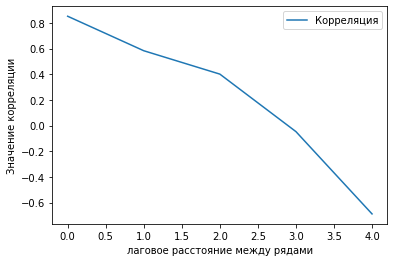

In [215]:
corr = []
start = 0 # начальная точка для проверки корреляций рядов
step = 10 # число точек для проверки корреляций рядов
h=0
yLen = yVal.shape[0]
yValF = yVal[start:start+step].flatten() # ряд истиных значений
yPredVal = predVal[start:start+step] # ряд предсказаний 
# смотрим лаговые корреляции yValF[:-i], yPredVal[i:] для лагов от 0 до 5
for i in range(5):
  corr.append(correlate(yValF[:-1-i], yPredVal[i:-1]))
  
plt.plot(corr, 
         label = 'Корреляция')
plt.xlabel('лаговое расстояние между рядами')
plt.ylabel('Значение корреляции')
plt.legend()
plt.show()

### Вывод: наилучший результат был достигнут при добавлении дополнительного слоя LSTM, а не увеличения количества нейронов в первом слое. Дополнительную точность добавили слои свертки и плотно связанный слой.